 # Applying topic modelling to LA Fitness reviews using Latent Dirichlet Allocation (LDA)
 Adaption from guide at https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

 ## Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import pyLDAvis
import pyLDAvis.gensim

import matplotlib.pyplot as plt

from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")


C:\Users\Yanchen\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\Yanchen\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Yanchen\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


 ## Prepare stopwords

In [2]:
stop_words = stopwords.words('english')
stop_words.extend(['la', 'fitness', 'gym'])


 ## Load data

In [3]:
df = pd.read_csv('./data/review.csv')
data = df.review.values.tolist()


 ## Tokenize and clean up text

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


data_words = list(sent_to_words(data))

print(data_words[:1])


[['it', 'was', 'my', 'first', 'meeting', 'with', 'chad', 'tuesday', 'would', 'recommend', 'him', 'derrick', 'helped', 'me', 'join', 'both', 'men', 'have', 'great', 'personality', 'no', 'pressure', 'glad', 'to', 'be', 'new', 'member', 'have', 'mentioned', 'the', 'club', 'to', 'many', 'friends', 'and', 'coworkers', 'several', 'have', 'expressed', 'interest', 'couldn', 'ask', 'for', 'more', 'was', 'member', 'at', 'the', 'jcc', 'for', 'years', 'and', 'it', 'didn', 'fit', 'my', 'needs', 'la', 'fitness', 'is', 'better', 'equipped', 'cleaner', 'and', 'the', 'equipment', 'is', 'more', 'than', 'had', 'hoped', 'for', 'wish', 'the', 'pool', 'was', 'bit', 'warmer', 'since', 'swim', 'for', 'physical', 'therapy', 'steam', 'room', 'would', 'be', 'fabulous', 'no', 'complaints']]


 ## Creating bigram and trigram models
 Consider two or three words that frequently occur together

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])


['it', 'was', 'my', 'first', 'meeting', 'with', 'chad', 'tuesday', 'would', 'recommend', 'him', 'derrick', 'helped', 'me', 'join', 'both', 'men', 'have', 'great', 'personality', 'no', 'pressure', 'glad', 'to', 'be', 'new', 'member', 'have', 'mentioned', 'the', 'club', 'to', 'many', 'friends', 'and', 'coworkers', 'several', 'have', 'expressed', 'interest', 'couldn', 'ask', 'for', 'more', 'was', 'member', 'at', 'the', 'jcc', 'for', 'years', 'and', 'it', 'didn', 'fit', 'my', 'needs', 'la', 'fitness', 'is', 'better', 'equipped', 'cleaner', 'and', 'the', 'equipment', 'is', 'more', 'than', 'had', 'hoped', 'for', 'wish', 'the', 'pool', 'was', 'bit', 'warmer', 'since', 'swim', 'for', 'physical_therapy', 'steam_room', 'would', 'be', 'fabulous', 'no', 'complaints']


 ## Remove stopwords, make bigrams, and lemmatize

In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out



In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=[
                                'NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['first', 'meeting', 'chad', 'tuesday', 'would', 'recommend', 'derrick', 'help', 'join', 'man', 'great', 'personality', 'pressure', 'glad', 'new', 'member', 'mention', 'club', 'many', 'friend', 'coworker', 'several', 'express', 'interest', 'ask', 'member', 'jcc', 'year', 'fit', 'need', 'better', 'equip', 'clean', 'equipment', 'hope', 'wish', 'pool', 'bit', 'warm', 'swim', 'physical_therapy', 'steam_room', 'would', 'fabulous', 'complaint']]


 ## Create dictionary and corpus

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1)]]


 ## Building the Topic Model

In [9]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=30,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=100,
                                            alpha='auto',
                                            per_word_topics=True)


 ## View topics in model

In [10]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(14,
  '0.040*"mom" + 0.037*"sister" + 0.037*"worker" + 0.024*"michelle" + '
  '0.022*"duty" + 0.021*"hung" + 0.020*"canceling" + 0.019*"satisfaction" + '
  '0.014*"sunday" + 0.013*"approve"'),
 (1,
  '0.045*"store" + 0.034*"group" + 0.027*"former" + 0.027*"corporation" + '
  '0.027*"site" + 0.023*"lane" + 0.022*"river" + 0.022*"benefit" + 0.021*"tom" '
  '+ 0.020*"becuase"'),
 (19,
  '0.040*"balance" + 0.032*"receptionist" + 0.026*"joe" + 0.023*"discuss" + '
  '0.021*"already" + 0.020*"ryan" + 0.020*"human" + 0.017*"boss" + '
  '0.014*"impression" + 0.013*"rudely"'),
 (13,
  '0.038*"active" + 0.033*"fire" + 0.025*"nasty" + 0.024*"spa" + 0.021*"non" + '
  '0.019*"expense" + 0.019*"nearby" + 0.019*"event" + 0.017*"enrollment" + '
  '0.015*"establish"'),
 (25,
  '0.084*"locker" + 0.034*"break" + 0.027*"theft" + 0.026*"catch" + '
  '0.020*"box" + 0.019*"opinion" + 0.018*"super" + 0.016*"many" + '
  '0.012*"obtain" + 0.012*"carlo"'),
 (23,
  '0.056*"numerous" + 0.049*"refuse" + 0.038*"une

 ## Compute model perplexity and coherence score
 These allow us to measure the quality of a topic model.

In [11]:
# Compute Perplexity
# a measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.076915202055019

Coherence Score:  0.46189899695129016


 ## Visualize topics and keywords
 The pyLDAvis package allows us to visualize
 the topics and their associated keywords generated by the LDA model

In [12]:
# ## Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.319729  0.000953       1        1  22.258080
16     0.311231  0.152286       2        1  15.185072
22     0.268935  0.167476       3        1  12.833232
2      0.191764 -0.111354       4        1   9.331725
24     0.198544 -0.271986       5        1   7.066542
6      0.177777  0.186479       6        1   6.680481
10     0.057133 -0.230429       7        1   2.913160
28     0.040792 -0.089906       8        1   2.352522
15     0.017582 -0.034569       9        1   2.194446
18    -0.005028 -0.077081      10        1   1.911451
7     -0.020201  0.017442      11        1   1.796068
3      0.000259 -0.008153      12        1   1.719690
0     -0.048842  0.023644      13        1   1.545215
29    -0.030639 -0.072655      14        1   1.076099
9     -0.071118  0.003210      15        1   0.872601
21    -0.084729  0.032114      16        1   0.855023
12    -0.062850  0.010103      17        1   0.843622
26    -0.081286 -0.006840      18        1   0.828621
8     -0.099225  0.028366      19        1   0.802947
5     -0.073573  0.006689      20        1   0.766666
17    -0.095908  0.018302      21        1   0.720493
4     -0.096979  0.038178      22        1   0.696941
20    -0.090813  0.029540      23        1   0.686590
19    -0.090182  0.045525      24        1   0.666714
25    -0.091642 -0.011407      25        1   0.660954
27    -0.096689  0.034861      26        1   0.610186
23    -0.094288  0.028122      27        1   0.591634
13    -0.114070  0.028531      28        1   0.590130
1     -0.112177  0.029733      29        1   0.475886
14    -0.123507  0.032826      30        1   0.467214, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
124   Default  1651.000000         cancel  1651.000000  30.0000  30.0000
57    Default  1689.000000     membership  1689.000000  29.0000  29.0000
161   Default  1978.000000           tell  1978.000000  28.0000  28.0000
247   Default  1122.000000       contract  1122.000000  27.0000  27.0000
150   Default  1596.000000            say  1596.000000  26.0000  26.0000
5     Default   706.000000           club   706.000000  25.0000  25.0000
113   Default  1647.000000          month  1647.000000  24.0000  24.0000
81    Default   898.000000       training   898.000000  23.0000  23.0000
168   Default  1019.000000        account  1019.000000  22.0000  22.0000
123   Default  1425.000000           call  1425.000000  21.0000  21.0000
53    Default  1929.000000             go  1929.000000  20.0000  20.0000
145   Default   724.000000       personal   724.000000  19.0000  19.0000
80    Default   776.000000        trainer   776.000000  18.0000  18.0000
26    Default   824.000000         member   824.000000  17.0000  17.0000
154   Default  1018.000000           sign  1018.000000  16.0000  16.0000
153   Default   664.000000        session   664.000000  15.0000  15.0000
82    Default   865.000000            use   865.000000  14.0000  14.0000
141   Default   935.000000        manager   935.000000  13.0000  13.0000
183   Default  1730.000000            get  1730.000000  12.0000  12.0000
176   Default   820.000000         charge   820.000000  11.0000  11.0000
42    Default   693.000000           year   693.000000  10.0000  10.0000
43    Default   734.000000           also   734.000000   9.0000   9.0000
64    Default   418.000000          class   418.000000   8.0000   8.0000
0     Default   765.000000            ask   765.000000   7.0000   7.0000
235   Default   349.000000           send   349.000000   6.0000   6.0000
115   Default  1000.000000            pay  1000.000000   5.0000   5.0000
173   Default   646.000000           back   646.000000   4.0000   4.0000
309   Default   898.000000           work   898.000000   3.0000   3.0000
1104  Default   430.000000          bal

 ## Finding the optimal number of topics

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model 
                       with respective number of topics
    """

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=30,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values



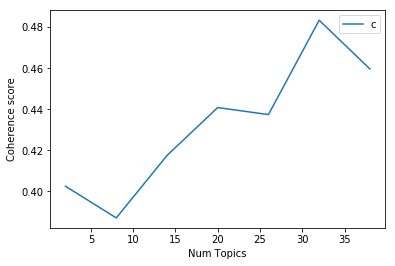

Num Topics = 2  has Coherence Value of 0.4025
Num Topics = 8  has Coherence Value of 0.3871
Num Topics = 14  has Coherence Value of 0.4175
Num Topics = 20  has Coherence Value of 0.4408
Num Topics = 26  has Coherence Value of 0.4374
Num Topics = 32  has Coherence Value of 0.4834
Num Topics = 38  has Coherence Value of 0.4596


In [14]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(
    dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

# Show graph
limit = 40
start = 2
step = 6
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


 Our initial estimate of 30 topics appears to be ideal.